In [6]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import gym
import rl_utils

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), 1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, 
            gamma) -> None:
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim)
        self.critic = ValueNet(state_dim, hidden_dim)
        self.actor_optimizier = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizier = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1)
        
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizier.zero_grad()
        self.critic_optimizier.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizier.step()
        self.critic_optimizier.step()
        

Iteration 9: 100%|██████████| 100/100 [00:07<00:00, 13.41it/s, episode=1000.0, return=200.000]


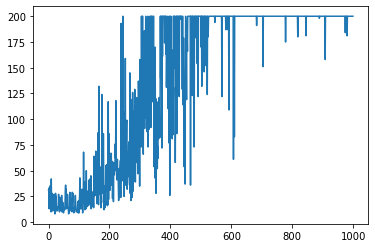

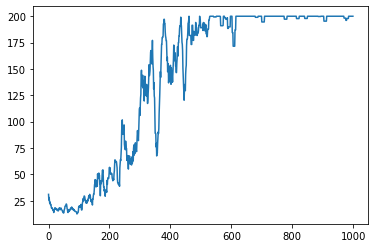

In [7]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

env_name = 'CartPole-v0'
env = gym.make(env_name)
np.random.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma)

return_list = []

@rl_utils.run_episodes(num_episodes, return_list)
def run_actorcritic():
    episode_return = 0
    transition_dict = {'states': [], 'rewards': [], 'actions': [], 'next_states': [], 'dones': []}
    state = env.reset()
    done = False
    while not done:
        action = agent.take_action(state)
        next_state, reward, done, _ = env.step(action)
        transition_dict['states'].append(state)
        transition_dict['actions'].append(action)
        transition_dict['rewards'].append(reward)
        transition_dict['next_states'].append(next_state)
        transition_dict['dones'].append(done)
        state = next_state
        episode_return += reward
    agent.update(transition_dict)
    return episode_return

run_actorcritic()

episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episode_list, mv_return)
plt.show()
